# TabNet Model Test

In this notebook, we'll test a training loop for the TabNet model 


In [1]:
import sys
sys.path.append('../src')

from models.lib.neural import *
from models.lib.data import *
from models.lib.train import *

import helper 
from helper import gene_intersection
from pytorch_tabnet.tab_network import TabNet

import torch.nn as nn 
import torch.optim as optim
import torch
from tqdm import tqdm
from torch.utils.data import Subset
import matplotlib.pyplot as plt 

t = helper.INTERIM_DATA_AND_LABEL_FILES_LIST
datafiles, labelfiles = zip(*t.items())
datafiles = [f'../data/interim/{f}' for f in datafiles]
labelfiles = [f'../data/processed/labels/{f}' for f in labelfiles]
refgenes = gene_intersection()

In [2]:
weights = total_class_weights(labelfiles, 'Type')

<BarContainer object of 17 artists>

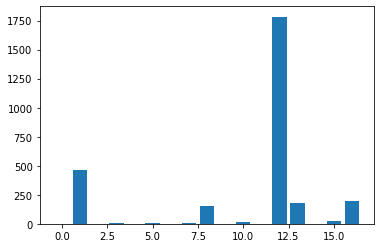

In [3]:
plt.bar(range(len(weights)), weights)

First, we'll define our train, val and test sets, then generate the associated DataLoaders and try training.

In [4]:
from models.lib.neural import TabNetGeneClassifier

model = TabNetGeneClassifier(
    input_dim=len(refgenes),
    output_dim=19
)

In [5]:
class SampleLoader(torch.utils.data.DataLoader):
    def __init__(self, refgenes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.refgenes = refgenes
        self.currgenes = self.dataset.columns 
            
    def __iter__(self):
        for batch in super().__iter__():
            yield clean_sample(batch[0], self.refgenes, self.currgenes), batch[1]

In [6]:
# test = SampleLoader(refgenes=refgenes, dataset=train, batch_size=11, num_workers=0)
# next(iter(test))

In [7]:
# next(iter(test))[0].shape

In [10]:
train, val, test = generate_loaders(datafiles, labelfiles, 'Type', refgenes=refgenes, shuffle=True, collocate=True)

In [12]:
next(iter(train))

(tensor([], size=(4, 0)), tensor([4, 4, 4, 4]))

## PyTorch-Lightning compatible TabNet architecture 

In [9]:
from models.lib.neural import TabNetGeneClassifier
import torch.functional as F
from torchmetrics.functional import accuracy, precision, recall 

base_model = TabNetGeneClassifier(
    input_dim=len(refgenes),
    output_dim=19,
)

class GeneClassifier(pl.LightningModule):
    """
        Initialize the gene classifier neural network

        Parameters:
        input_dim: Number of features in the inpute matrix 
        output_dim: Number of classes
        weights: Weights to use in loss calculation to account for imbalance in class size 
        params: Dictionary of hyperparameters to use. Must include width, layers, lr, momentum, weight_decay
        metrics: Dictionary of metrics to log, where keys are metric names and values are torchmetrics.functional methods
        weighted_metrics: If True, use class-weighted calculation in metrics. Otherwise, use default 'micro' calculation.
    """
    def __init__(
        self, 
        input_dim, 
        output_dim,
        base_model=None,
        optimizer=torch.optim.Adam,
        optim_params: Dict[str, float]={
            'lr': 0.001,
            'weight_decay': 0.01,
        },
        metrics: Dict[str, Callable]={
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
        },
        weighted_metrics=False,
        *args,
        **kwargs,
    ):
        super().__init__()
        print(f'Model initialized. {input_dim = }, {output_dim = }. Metrics are {metrics.keys()} and {weighted_metrics = }')

        if base_model is None:
            self.base_model = TabNetGeneClassifier(
                input_dim=input_dim,
                output_dim=output_dim,
                *args,
                **kwargs,
            )
        else:
            self.base_model = base_model
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.optimizer = optimizer
        self.optim_params = optim_params
        self.metrics = metrics
        self.weighted_metrics = weighted_metrics
        
    def forward(self, x):
        out = self.base_model(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = F.cross_entropy(y_hat, y)
        
        self.log("train_loss", loss, logger=True, on_epoch=True, on_step=True)
        self._compute_metrics(y_hat, y, 'train')
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)

        self.log("val_loss", val_loss, logger=True, on_epoch=True, on_step=True)
        self._compute_metrics(y_hat, y, 'val')
        
        return val_loss
    
    def _compute_metrics(self, y_hat, y, tag, on_epoch=True, on_step=True):
        for name, metric in self.metrics.items():
            if not self.weighted_metrics: # We dont consider class support in calculation
                val = metric(y_hat, y, average='weighted', num_classes=self.output_dim)
                self.log(
                    f"weighted_{tag}_{name}", 
                    val, 
                    on_epoch=on_epoch, 
                    on_step=on_step,
                    logger=True,
                )
            else:
                val = metric(y_hat, y)
                self.log(
                    f"{tag}_{name}", 
                    val, 
                    on_epoch=on_epoch, 
                    on_step=on_step,
                    logger=True,
                )

    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), **self.optim_params)
        return optimizer

In [10]:
base_model.input_dim

16604

In [11]:
classifier = GeneClassifier(
    input_dim=len(refgenes),
    output_dim=19,
)

Model initialized. input_dim = 16604, output_dim = 19. Metrics are dict_keys(['accuracy', 'precision', 'recall']) and weighted_metrics = False


In [22]:
import pytorch_lightning as pl 
from typing import *
import torch.nn.functional as F

from itertools import chain

def custom_collate(sample, refgenes, currgenes):
    data = clean_sample(torch.stack([x[0] for x in sample]), refgenes, currgenes)
    labels = torch.tensor([x[1] for x in sample])
    return data, labels

class CollateLoader(torch.utils.data.DataLoader):
    def __init__(self, refgenes, currgenes, *args, **kwargs):
        collate_fn = functools.partial(custom_collate, refgenes=refgenes, currgenes=currgenes)
        super().__init__(collate_fn = collate_fn, *args, **kwargs)

class SequentialLoader:
    def __init__(self, dataloaders):
        self.dataloaders = dataloaders

    def __len__(self):
        return sum([len(dl) for dl in self.dataloaders])

    def __iter__(self):
        yield from chain(*self.dataloaders)
                
class GeneDataModule(pl.LightningDataModule):
    def __init__(
        self, 
        datafiles: List[str],
        labelfiles: List[str],
        class_label: str,
        data_path: str,
        refgenes: List[str],
        batch_size: int=16,
        num_workers=32,
        shuffle=False,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.__dict__.update(**kwargs)

        self.datafiles = datafiles
        self.labelfiles = labelfiles
        self.class_label = class_label
        self.refgenes = refgenes
        self.shuffle = shuffle
        self.data_path = data_path
        
        self.num_workers = num_workers
        self.batch_size = batch_size
        
        self.trainloaders = []
        self.valloaders = []
        self.testloaders = []
        
        self.args = args
        self.kwargs = kwargs
        
    def prepare_data(self):
        data_path = self.data_path
        info =  helper.INTERIM_DATA_AND_LABEL_FILES_LIST

        datafiles = info.keys()
        labelfiles = [info[file] for file in datafiles]

        for datafile, labelfile in zip(datafiles, labelfiles):
            dfpath = os.path.join(data_path, 'interim', datafile)
            lfpath = os.path.join(data_path, 'processed', 'labels', labelfile)

            if not os.path.isfile(dfpath):
                print(f'Downloading {dfpath}')
                download(
                    remote_name=os.path.join('jlehrer/expression_data/interim/', datafile),
                    file_name=dfpath
                )
            else:
                print(f'{dfpath} exists, continuing...')

            if not os.path.isfile(lfpath):
                print(f'Downloading {lfpath}')
                download(
                    remote_name=os.path.join('jlehrer/expression_data/labels/', labelfile),
                    file_name=lfpath,
                )
            else:
                print(f'{lfpath} exists, continuing...\n')    
                
    def setup(self, stage: Optional[str] = None):
        trainloaders, valloaders, testloaders = generate_loaders(
            datafiles=self.datafiles,
            labelfiles=self.labelfiles,
            class_label=self.class_label,
            refgenes=self.refgenes,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=self.shuffle,
            *self.args,
            **self.kwargs
        )
        
        self.trainloaders = SequentialLoader(trainloaders)
        self.valloaders = SequentialLoader(valloaders)
        self.testloaders = SequentialLoader(testloaders)
        
    def train_dataloader(self):
        return self.trainloaders

    def val_dataloader(self):
        return self.valloaders

    def test_dataloader(self):
        return self.testloaders

In [13]:
module = GeneDataModule(
    datafiles=datafiles, 
    labelfiles=labelfiles, 
    class_label='Type'
    data_path='../data', 
    refgenes=refgenes,
    skip=3,
    normalize=True,
    batch_size=8,
    num_workers=0,
)

In [14]:
from pytorch_lightning import Trainer 
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project='TabNet Cell Type Classifier', name='Tabnet with Metrics')
trainer = Trainer(logger=wandb_logger)

trainer.fit(classifier, datamodule=module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
wandb: Currently logged in as: jlehrer1 (use `wandb login --relogin` to force relogin)



  | Name       | Type                 | Params
----------------------------------------------------
0 | base_model | TabNetGeneClassifier | 1.1 M 
----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.407     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/julian/miniconda3/envs/base-data-science/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [17]:
test = (
    i+1 for i in range(3)
)

In [18]:
a, b, c = test

In [20]:
a, b, c

(1, 2, 3)

In [13]:
sum(i for i in range(5))

10

In [19]:
from helper import download

def prepare_data(data_path):
    info =  helper.INTERIM_DATA_AND_LABEL_FILES_LIST

    datafiles = info.keys()
    labelfiles = [info[file] for file in datafiles]

    os.makedirs(os.path.join(data_path, 'interim'), exist_ok=True)
    os.makedirs(os.path.join(data_path, 'processed', 'labels'), exist_ok=True)


    for datafile, labelfile in zip(datafiles, labelfiles):
        dfpath = os.path.join(data_path, 'interim', datafile)
        lfpath = os.path.join(data_path, 'processed', 'labels', labelfile)

        if not os.path.isfile(dfpath):
            download(
                remote_name=os.path.join('jlehrer/expression_data/interim/', datafile),
                file_name=dfpath,
            )
        else:
            print(f'{dfpath} exists, continuing...')

        if not os.path.isfile(lfpath):
            print(f'Downloading {lfpath}')
            download(
                remote_name=os.path.join('jlehrer/expression_data/labels/', labelfile),
                file_name=dfpath,
            )
        else:
            print(f'{lfpath} exists, continuing...\n')    


In [20]:
prepare_data('../data')

../data/interim/primary_bhaduri_T.csv exists, continuing...
../data/processed/labels/primary_bhaduri_labels.csv exists, continuing...

../data/interim/allen_cortex_T.csv exists, continuing...
../data/processed/labels/allen_cortex_labels.csv exists, continuing...

../data/interim/allen_m1_region_T.csv exists, continuing...
../data/processed/labels/allen_m1_region_labels.csv exists, continuing...

../data/interim/whole_brain_bhaduri_T.csv exists, continuing...
../data/processed/labels/whole_brain_bhaduri_labels.csv exists, continuing...



In [28]:
t.keys

dict_keys(['a', 'b'])

In [30]:
t.values()

dict_values([1, 2])